In [1]:
import os
import PIL
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import cv2
import importlib
from func import *

# 요청한 이미지에 대해 Grad-CAM

/Users/skku_aws23/Desktop/cursor_project/github/rsna-pneumonia-detection-challenge/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


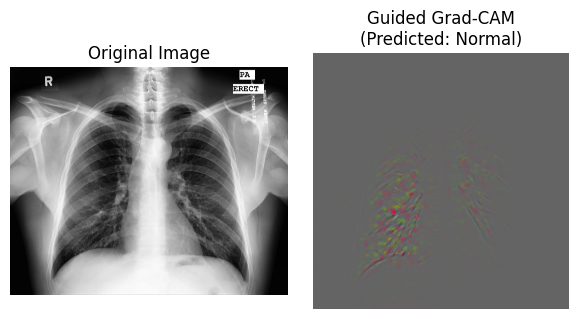

In [11]:
# 7. guided grad-cam 실행 (1~6은 func.py에)
if __name__ == '__main__':
    image_path = 'data/Lung Segmentation/CXR_png/MCUCXR_0103_0.png'

    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 3)
    checkpoint = torch.load('models/jm_best_model.pth', map_location='cpu')
    model.load_state_dict(checkpoint)
    model.eval()

    input_tensor, original_img = preprocess_image(image_path)

    # Grad-CAM
    grad_cam = GradCAM(model, target_layer='layer4')
    cam, class_idx = grad_cam(input_tensor)
    predicted_class_name = class_names[class_idx]

    # Guided Backpropagation
    guided_bp = GuidedBackprop(model)
    guided_grad = guided_bp(input_tensor, class_idx)

    # Guided Grad-CAM
    guided_gradcam = guided_grad * cam[None, :, :]
    # # multiply
    # guided_gradcam = guided_grad * cam[None, :, :]

    # # normalize
    # guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (guided_gradcam.max() - guided_gradcam.min())

    # 시각화    
    visualize(original_img, guided_gradcam, predicted_class_name)

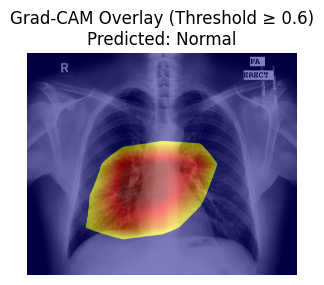

In [3]:
def overlay_cam_on_image_threshold(original_img, cam, threshold=0.5):
    """
    cam: normalized cam (0~1)
    threshold: 보여줄 최소 임계값 (0.0~1.0)
    """

    # Resize CAM to match image size
    cam_resized = cv2.resize(cam, original_img.size)

    # 임계값 이하 제거 (0으로 마스킹)
    cam_thresh = np.where(cam_resized >= threshold, cam_resized, 0)

    # ColorMap 적용
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_thresh), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지
    original_np = np.array(original_img)

    # Overlay
    overlay = np.uint8(0.5 * heatmap + 0.5 * original_np)

    return overlay



def visualize_overlay_threshold(original_img, cam, predicted_class_name, threshold=0.5):
    overlay = overlay_cam_on_image_threshold(original_img, cam, threshold)
    plt.figure(figsize=(3, 3))
    plt.imshow(overlay)
    plt.title(f"Grad-CAM Overlay (Threshold ≥ {threshold})\nPredicted: {predicted_class_name}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()



visualize_overlay_threshold(original_img, cam, predicted_class_name, threshold=0.6)


# 폐 영역 마스크에 Grad-CAM 오버레이

In [12]:
from torchvision.transforms import InterpolationMode

mask_image = 'data/Lung Segmentation/masks/MCUCXR_0103_0.png'
mask_png = Image.open(mask_image)

transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor()
])

mask_np = np.array(mask_png)
re_cam = cv2.resize(cam, (mask_np.shape[1], mask_np.shape[0]))


폐 영역 픽셀 수: 5728318
(4020, 4892)


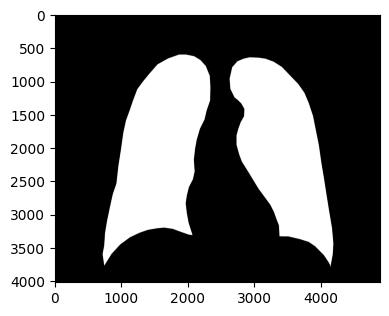

In [13]:
# 0~1 정규화
mask_bin = (mask_np > 0).astype(np.float32)  # 0.0, 1.0

lung = mask_bin == 1
lung_area = np.sum(lung)
print(f'폐 영역 픽셀 수: {lung_area}')
print(mask_np.shape)

plt.figure(figsize=(4, 4))
plt.imshow(mask_np, cmap='gray')
plt.tight_layout()
plt.show()

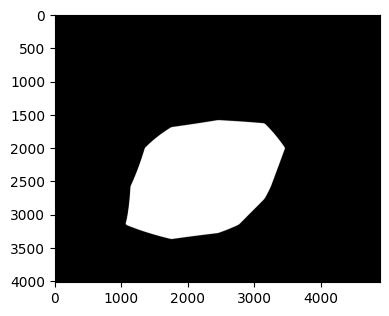

In [14]:
# 병변 영역 binary화
cam_bin = (re_cam >= 0.6).astype(np.float32)

# lesion_cam = cam_bin == 1
# lesion_area = np.sum(lesion_cam)
# print(f'병변 영역 픽셀 수: {lesion_area}')
# print(cam_bin.shape)
plt.figure(figsize=(4, 4))
plt.imshow(cam_bin, cmap='gray')
plt.tight_layout()
plt.show()

In [15]:
# 사이즈 비교
print(f'마스크 사이즈: {mask_bin.shape}, 값 분포: {np.unique(mask_bin)}')
print(f'cam 사이즈: {cam_bin.shape}, 값 분포: {np.unique(cam_bin)}')

마스크 사이즈: (4020, 4892), 값 분포: [0. 1.]
cam 사이즈: (4020, 4892), 값 분포: [0. 1.]


# 병변 영역 비율 계산

병변 영역 픽셀 수: 1774081.0
(4020, 4892)


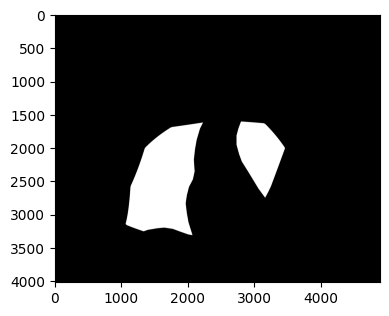

In [16]:
lesion_mask = cam_bin * mask_bin
lesion_area = np.sum(lesion_mask)
print(f'병변 영역 픽셀 수: {lesion_area}')
print(cam_bin.shape)

plt.figure(figsize=(4, 4))
plt.imshow(lesion_mask, cmap='gray')
plt.tight_layout()
plt.show()

# 병변 면적 비율 구하기!!

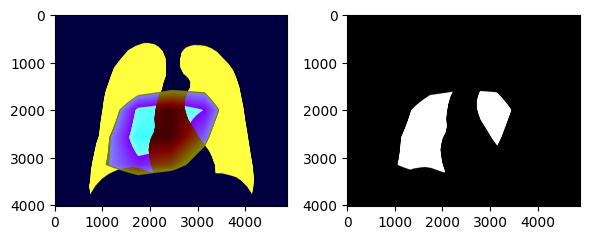

폐 영역 픽셀 수: 5728318
병변 영역 픽셀 수: 1774081.0
비율: 30.97%


In [18]:
from func import overlay_cam_on_image

overlay = overlay_cam_on_mask(mask_np, cam, 0.6)


plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(overlay)
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.imshow(lesion_mask, cmap='gray')
plt.tight_layout()
plt.show()

print(f'폐 영역 픽셀 수: {lung_area}')
print(f'병변 영역 픽셀 수: {lesion_area}')
print(f'비율: {lesion_area/lung_area*100:.2f}%')